# Imports

In [1]:
%matplotlib widget
from scipy.io import loadmat
from ipywidgets import interact, IntSlider, fixed
import matplotlib.pyplot as plt
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Data Loading and Pre-processing

### Parameters

In [2]:
scan_id = "01"
patient_id = "18"
scan_type = "FF"
run = "1"
ssim_kwargs = {"K1": 0.03, "K2": 0.06, "win_size": 11}
plotting = "index"  # "index" or "height" or "width"

# scan_id = "01"
# patient_id = "10"
# scan_type = "HF"
# run = "1"
# ssim_kwargs = {"K1": 0.03, "K2": 0.06, "win_size": 15}
# plotting = "index" # "index" or "height" or "width"

### Loading & Pre-processing data

In [3]:
# Load the MATLAB files
if scan_type == "FF":
    gt_mat = loadmat(f"Data/3D_recon/{scan_type}/recon_p{patient_id}.{scan_type}{scan_id}.u_FDK_ROI_fullView.mat")
    fdk_mat = loadmat(f"Data/3D_recon/{scan_type}/recon_p{patient_id}.{scan_type}{scan_id}.u_FDK_ROI.mat")
    pl_mat = loadmat(f"Data/3D_recon/{scan_type}/recon_p{patient_id}.{scan_type}{scan_id}.u_PL_ROI.b1.mat")
else:
    gt_mat = loadmat(f"Data/3D_recon/{scan_type}/recon_p{patient_id}.{scan_type}{scan_id}.u_FDK_full.mat")
    fdk_mat = loadmat(f"Data/3D_recon/{scan_type}/recon_p{patient_id}.{scan_type}{scan_id}.u_FDK.mat")
    pl_mat = loadmat(f"Data/3D_recon/{scan_type}/recon_p{patient_id}.{scan_type}{scan_id}.u_PL.b1.iter200.mat")


# Print the keys of the loaded dictionaries
print(gt_mat.keys())
print(fdk_mat.keys())
print(pl_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'u_FDK_ROI_fullView'])
dict_keys(['__header__', '__version__', '__globals__', 'u_FDK_ROI'])
dict_keys(['__header__', '__version__', '__globals__', 'u_PL_ROI'])


In [4]:
# Extract the scan data
if scan_type == "FF":
    gt = gt_mat['u_FDK_ROI_fullView']
    fdk = fdk_mat['u_FDK_ROI']
    pl = pl_mat['u_PL_ROI']
else:
    gt = gt_mat['u_FDK_full']
    fdk = fdk_mat['u_FDK']
    pl = pl_mat['u_PL']

# Check their shapes
print("Shapes:")
print("GT:", gt.shape)
print("FDK:", fdk.shape)
print("PL:", pl.shape)

# Remove the first and last 20 slices
gt = gt[..., 20:-20]
fdk = fdk[..., 20:-20]
pl = pl[..., 20:-20]

if scan_type == "FF":
    # Crop
    gt = gt[128:-128, 128:-128]
    fdk = fdk[128:-128, 128:-128]
    pl = pl[128:-128, 128:-128]

    # Check the new shapes (for verification)
    print("\nShapes after removing slices:")
    print("GT:", gt.shape)
    print("FDK:", fdk.shape)
    print("PL:", pl.shape)

Shapes:
GT: (512, 512, 200)
FDK: (512, 512, 200)
PL: (512, 512, 200)

Shapes after removing slices:
GT: (256, 256, 160)
FDK: (256, 256, 160)
PL: (256, 256, 160)


In [5]:
# NOTE: This is a numpy array, not a torch tensor
ddCNN = torch.load(f"Data/3D_recon/{scan_type}/p{patient_id}.{scan_type}{scan_id}_IResNet_MK6_DS{14 if scan_type == 'FF' else 13}.2_run{run}_3D.pt", weights_only=False)

# The loaded array should already have the correct number of slices
ddCNN.shape

(256, 256, 160)

In [6]:
# Get the tumor location
tumor_location = torch.load("Data/3D_recon/tumor_location_FF.pt" if scan_type == "FF" else "Data/3D_recon/tumor_location.pt", weights_only=False)[int(patient_id), int(scan_id)]
if scan_type == "FF":
    # Adjust the tumor location to match the cropped images
    tumor_location[:2] = tumor_location[:2] - 128
tumor_location

array([132, 122, 100], dtype=int32)

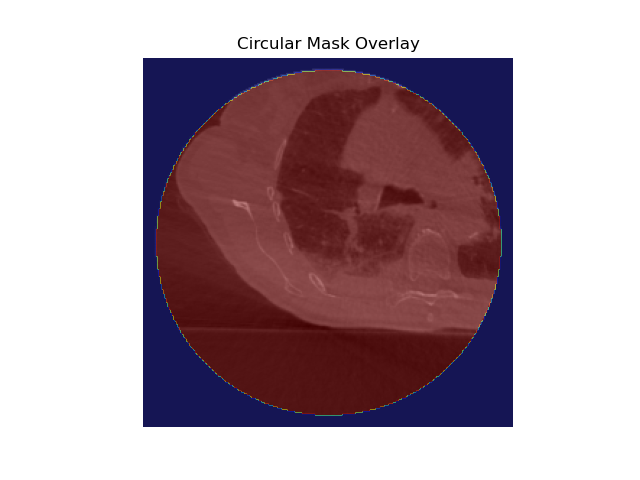

In [7]:
if plotting == "index":
    if scan_type == "FF":
        # gt is your ground truth volume of shape (H, W, N)
        first_slice = gt[:, :, 0]

        # 1. Create a binary foreground mask from non-zero pixels
        fg = first_slice != 0

        # 2. Estimate center as image center
        H, W = first_slice.shape
        cy, cx = H / 2.0, W / 2.0

        # 3. Compute distances of all foreground pixels to center
        ys, xs = np.nonzero(fg)
        dists = np.sqrt((ys - cy)**2 + (xs - cx)**2)

        # 4. Estimate radius as the 99th percentile of those distances
        radius = np.percentile(dists, 99)

        # 5. Build your circular mask
        Y, X = np.ogrid[:H, :W]
        mask = (Y - cy)**2 + (X - cx)**2 <= radius**2

        # Plot the mask on top of the first slice
        plt.imshow(first_slice, cmap='gray', alpha=1.0)
        plt.imshow(mask, cmap='jet', alpha=0.5)
        plt.title("Circular Mask Overlay")
        plt.axis('off')
        plt.show()
    else:
        mask = np.ones(gt.shape[0:2], dtype=bool)  # Create a mask of ones for HF scans
elif plotting == "height":
    # Swap the axes to plot along the height
    gt = np.swapaxes(gt, 0, 2)
    fdk = np.swapaxes(fdk, 0, 2)
    pl = np.swapaxes(pl, 0, 2)
    ddCNN = np.swapaxes(ddCNN, 0, 2)
    temp = tumor_location.copy()
    tumor_location = np.array([temp[2], temp[1], temp[0]])  # Adjust the tumor location for height plotting
    mask = np.ones(gt.shape[0:2], dtype=bool)  # Create a mask of ones
elif plotting == "width":
    # Swap the axes to plot along the width
    gt = np.swapaxes(gt, 1, 2)
    fdk = np.swapaxes(fdk, 1, 2)
    pl = np.swapaxes(pl, 1, 2)
    ddCNN = np.swapaxes(ddCNN, 1, 2)
    temp = tumor_location.copy()
    tumor_location = np.array([temp[0], temp[2], temp[1]])
    mask = np.ones(gt.shape[0:2], dtype=bool)

In [8]:
print("Before normalization:")
print("GT min/max   ", np.round(gt.min(), 3), np.round(gt.max(), 3))
print("FDK min/max  ", np.round(fdk.min(), 3), np.round(fdk.max(), 3))
print("PL min/max   ", np.round(pl.min(), 3), np.round(pl.max(), 3))
print("DDCNN min/max", np.round(ddCNN.min(), 3), np.round(ddCNN.max(), 3))

# Cap the values to [0, 0.04] in GT, FDK, and PL
gt = np.clip(gt, 0, 0.04)
fdk = np.clip(fdk, 0, 0.04)
pl = np.clip(pl, 0, 0.04)

# Normalize the images to the range [0, 1]
gt = (gt - gt.min()) / (gt.max() - gt.min())
fdk = (fdk - fdk.min()) / (fdk.max() - fdk.min())
pl = (pl - pl.min()) / (pl.max() - pl.min())

print("\nAfter normalization:")
print("GT min/max   ", np.round(gt.min(), 3), np.round(gt.max(), 3))
print("FDK min/max  ", np.round(fdk.min(), 3), np.round(fdk.max(), 3))
print("PL min/max   ", np.round(pl.min(), 3), np.round(pl.max(), 3))
print("DDCNN min/max", np.round(ddCNN.min(), 3), np.round(ddCNN.max(), 3))

Before normalization:
GT min/max    -0.013 0.108
FDK min/max   -0.021 0.104
PL min/max    0.0 0.095
DDCNN min/max -0.025 1.029

After normalization:
GT min/max    0.0 1.0
FDK min/max   0.0 1.0
PL min/max    0.0 1.0
DDCNN min/max -0.025 1.029


# Plotting

### Plotting functions

In [9]:
def show_volumes(gt, recons, recon_titles, slice_idx):
    """
    gt          : ndarray, ground truth volume (H, W, N)
    recons      : list of ndarrays, reconstructions (each H, W, N)
    recon_titles: list of str, titles for recs
    slice_idx   : int, which slice to display
    """

    # build full lists
    volumes = [gt] + recons
    titles  = ['Ground Truth'] + recon_titles

    # proceed without per‐slice normalization
    n = len(volumes)
    fig, axes = plt.subplots(2, n, figsize=(3*n, 8))

    # first row: original volumes (now scaled)
    for i, (vol, title) in enumerate(zip(volumes, titles)):
        ax = axes[0, i]
        slice_ = vol[..., slice_idx]
        # normalize to [0, 1]
        # slice_ = (slice_ - np.min(slice_)) / (np.max(slice_) - np.min(slice_)) # TODO normalize?
        ax.imshow(slice_ * mask, cmap='gray', vmin=0, vmax=1) # TODO mask?
        ax.set_title(title)
        ax.axis('off')

    # add a thin red arrow when the slice index matches the tumor location
    if slice_idx == tumor_location[2]:
        y, x, _ = tumor_location
        for ax in axes.flat:
            ax.annotate(
                '',
                xy=(x, y),
                xytext=(x + 30, y - 30) if scan_type == "FF" else (x + 60, y - 60),
                arrowprops=dict(color='red', lw=1),
            )

    # second row: SSIM maps (skip GT in col 0)
    axes[1, 0].axis('off')
    ssim_axes = []
    for i in range(1, n):
        ax = axes[1, i]
        gt_slice    = gt[..., slice_idx]
        recon_slice = recons[i-1][..., slice_idx]
        # normalize slices to [0, 1]
        # gt_slice    = (gt_slice - np.min(gt_slice)) / (np.max(gt_slice) - np.min(gt_slice)) # TODO normalize?
        # recon_slice = (recon_slice - np.min(recon_slice)) / (np.max(recon_slice) - np.min(recon_slice)) # TODO normalize?
        _, ssim_map = ssim(
            gt_slice, recon_slice,
            full=True,
            data_range=1.0,
            **ssim_kwargs,
        )
        im = ax.imshow(ssim_map * mask, cmap='viridis', vmin=0, vmax=1) # TODO mask?
        ax.set_title(f'SSIM {recon_titles[i-1]}')
        ax.axis('off')
        ssim_axes.append(ax)

    # shared colorbar for SSIM
    fig.colorbar(im, ax=ssim_axes, location='right', fraction=0.02, pad=0.02)
    fig.subplots_adjust(right=0.85)

    plt.show()

# compute PSNR vs. slice index
def psnr_per_slice(gt_vol, rec_vol, mask=None):
    # normalize volumes to [0, 1]
    # gt_vol = (gt_vol - np.min(gt_vol * mask)) / (np.max(gt_vol * mask) - np.min(gt_vol * mask)) # TODO
    # rec_vol = (rec_vol - np.min(rec_vol * mask)) / (np.max(rec_vol * mask) - np.min(rec_vol * mask)) # TODO
    mse = np.mean((gt_vol - rec_vol)**2, axis=(0,1), where=mask)
    psnr = 20 * np.log10(np.max(gt_vol * mask, axis=(0,1))) - 10 * np.log10(mse)

    # mask infs to nan
    psnr[np.isinf(psnr)] = np.nan

    return psnr

def mssim_per_slice(gt_vol, rec_vol, mask=None):
    # normalize volumes to [0, 1]
    # gt_vol = (gt_vol - np.min(gt_vol * mask[:, :, None])) / (np.max(gt_vol * mask[:, :, None]) - np.min(gt_vol * mask[:, :, None])) # TODO
    # rec_vol = (rec_vol - np.min(rec_vol * mask[:, :, None])) / (np.max(rec_vol * mask[:, :, None]) - np.min(rec_vol * mask[:, :, None])) # TODO
    ssim_values = []
    for i in range(gt_vol.shape[2]):
        _, ssim_map = ssim(
            gt_vol[:, :, i], rec_vol[:, :, i],
            data_range=1.0,
            full=True,
            **ssim_kwargs,
        )
        ssim_value = np.mean(ssim_map[mask])
        ssim_values.append(ssim_value)
    return np.array(ssim_values)

def plot_psnr_mssim(gt, fdk, pl, ddCNN, mask=None):
    # gather PSNR curves
    psnr_fdk   = psnr_per_slice(gt, fdk, mask=mask[:, :, None])
    psnr_pl    = psnr_per_slice(gt, pl, mask=mask[:, :, None])
    psnr_ddcnn = psnr_per_slice(gt, ddCNN, mask=mask[:, :, None])

    # gather MSSIM curves
    mssim_fdk   = mssim_per_slice(gt, fdk, mask=mask)
    mssim_pl    = mssim_per_slice(gt, pl, mask=mask)
    mssim_ddcnn = mssim_per_slice(gt, ddCNN, mask=mask)

    num_slices = gt.shape[2]

    # plot MSSIM and PSNR curves and histograms as subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Top row: MSSIM vs slice index and histogram
    axes[0, 0].plot(np.arange(num_slices), mssim_fdk,   label='FDK',  color='blue')
    axes[0, 0].plot(np.arange(num_slices), mssim_pl,    label='PL',   color='orange')
    axes[0, 0].plot(np.arange(num_slices), mssim_ddcnn, label='DDCNN', color='green')
    axes[0, 0].set_xlabel('Slice index')
    axes[0, 0].set_ylabel('MSSIM')
    axes[0, 0].set_title('MSSIM vs. Slice Index')
    axes[0, 0].legend(loc='best')

    axes[0, 1].hist(mssim_fdk,   bins=50, alpha=0.5, label='FDK',   color='blue')
    axes[0, 1].hist(mssim_pl,    bins=50, alpha=0.5, label='PL',    color='orange')
    axes[0, 1].hist(mssim_ddcnn, bins=50, alpha=0.5, label='DDCNN', color='green')
    axes[0, 1].set_xlabel('MSSIM')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Histogram of MSSIM Values')
    axes[0, 1].legend(loc='best')

    # Bottom row: PSNR vs slice index and histogram
    axes[1, 0].plot(np.arange(num_slices), psnr_fdk,   label='FDK', color='blue')
    axes[1, 0].plot(np.arange(num_slices), psnr_pl,    label='PL', color='orange')
    axes[1, 0].plot(np.arange(num_slices), psnr_ddcnn, label='DDCNN', color='green')
    axes[1, 0].set_xlabel('Slice index')
    axes[1, 0].set_ylabel('PSNR (dB)')
    axes[1, 0].set_title('PSNR vs. Slice Index')
    axes[1, 0].legend(loc='best')

    axes[1, 1].hist(psnr_fdk,   bins=50, alpha=0.5, label='FDK',   color='blue')
    axes[1, 1].hist(psnr_pl,    bins=50, alpha=0.5, label='PL',    color='orange')
    axes[1, 1].hist(psnr_ddcnn, bins=50, alpha=0.5, label='DDCNN', color='green')
    axes[1, 1].set_xlabel('PSNR (dB)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Histogram of PSNR Values')
    axes[1, 1].legend(loc='best')

    plt.tight_layout()
    plt.show()

### Plots

In [10]:
recons = [fdk, pl, ddCNN]
recon_titles = [
    'FDK Reconstruction',
    'PL Reconstruction',
    'DDCNN Reconstruction'
]

print("NOTE: Tumor is in 'slice'", tumor_location[2])

_ = interact(
    show_volumes,
    gt=fixed(gt),
    recons=fixed(recons),
    recon_titles=fixed(recon_titles),
    slice_idx=IntSlider(
        min=0,
        max=gt.shape[2] - 1,
        step=1,
        value=tumor_location[2],
        description="'Slice'",
    )
)

NOTE: Tumor is in 'slice' 100


interactive(children=(IntSlider(value=100, description="'Slice'", max=159), Output()), _dom_classes=('widget-i…

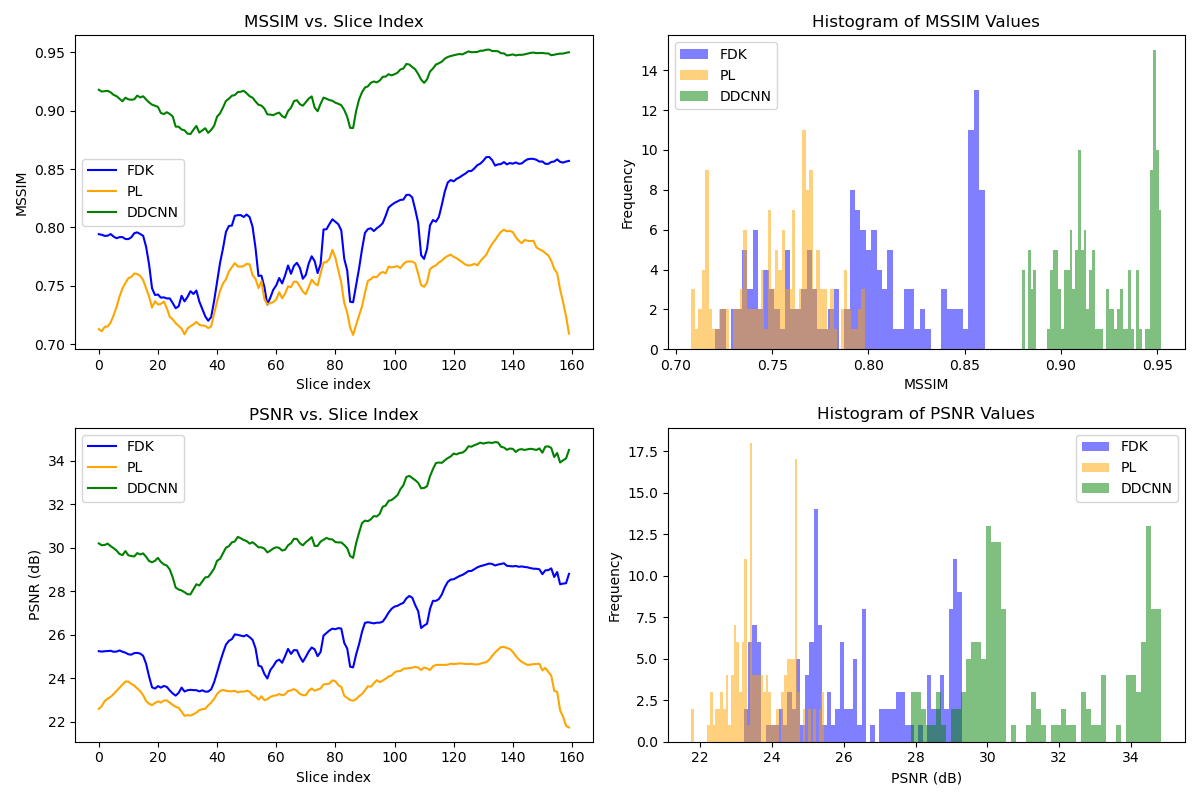

In [11]:
plot_psnr_mssim(gt, fdk, pl, ddCNN, mask=mask)